
The goal of this project is to predict the average rating of books. The target variable, representing average book ratings, is continuous and non-categorical. Hence, the problem is approached as a regression task rather than classification. This notebook provides a basic overview of implementing two regression techniques: linear regression and ensemble tree-based regression. Linear regression, a traditional and easily interpretable method, assumes a linear relationship between the input features and the target variable. Conversely, ensemble tree-based regression methods, such as the Gradient Boosting Regressor, employ decision trees in an ensemble manner to capture intricate nonlinear relationships between features and target variables. The scikit-learn library will be utilized to access the built-in LinearRegression model and ensemble.GradientBoostingRegressor. The mean squared error (MSE), r2 score and mean absolute error (MEA) are chosen as the evaluation metric for assessing the performance of these models.

## Importing Necessary Libraries

In [14]:
# import necessary libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

## Data Reading and Preparation

The dataframe is read from dataframe_forML.csv file. The steps for data cleaning and feature engineering that lead to this file are found in DataCleaningFeatEng.ipynb notebook. Please look at it for more details

In [3]:
# read the dataframe
df = pd.read_csv("dataframe_forML.csv")
df.head()

,num_pages,ratings_count,text_reviews_count,edition_avgRating,added_toShelves,num_contributors,book_age,size_of_publisher,size_of_author,is_english,book_count,is_serie,has_edition,edition_year,edition_month,category_audio,category_hardcover,category_other,category_paperback
0,652,2095690,27591,4.57,4405980.0,2,1,3,2,1,2,1,1,2006,9,False,False,False,True
1,870,2153167,29221,4.50,4518536.0,2,1,3,2,1,1,1,1,2004,9,False,False,False,True
2,352,6333,244,4.05,7469.0,1,1,3,2,1,2,1,1,2003,11,False,True,False,False
3,435,2339585,36325,4.57,5223956.0,2,1,3,2,1,2,1,1,2004,5,False,False,False,True
4,2690,41428,164,4.72,172736.0,2,1,3,2,1,1,1,0,2004,9,False,False,False,True


In [4]:
features = ['num_pages', 'ratings_count', 'text_reviews_count',
       'added_toShelves', 'num_contributors', 'size_of_publisher',
       'size_of_author', 'is_english', 'book_count', 'is_serie', 'has_edition',
       'book_age', 'edition_year', 'edition_month', 'category_audio',
       'category_hardcover', 'category_other', 'category_paperback']

target = ["edition_avgRating"]

train_test_split is used to split the data into training data and testing data with 70% for train and 30% for test. Data is normalized using MinMaxScaler(), which scales the features in a range [0,1]. In general, normalization helps prevent overfitting, makes the learning process faster, and improves prediction accuracy.

In [6]:
# split data into 70% train and 30% test
df_train, df_test = train_test_split(df, test_size = 0.3, random_state=42)

# X_train, y_train, X_test, y_test
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

# scale the data 
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Model Initialization

In [9]:
# initializing the models

# linear regression - with basic implementation
reg_model = LinearRegression() 

# hyperparameters for the Gradient Boosting Regressor
ensemble_params = {
    "n_estimators": 1000, # number of trees
    "max_depth": 5, # maximum tree depth
    "min_samples_split": 5, # minimum number of samples required to split an internal node
    "learning_rate": 0.01, # learning rate
    "loss": "squared_error", # loss to minimize the mse
}
ensemble_model = ensemble.GradientBoostingRegressor(**ensemble_params, random_state=42)

In [10]:
# fit the models on the training data
reg_model.fit(X_train, y_train)
ensemble_model.fit(X_train, y_train)

c:\Users\kader\anaconda3\envs\book-rating_prediction\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(learning_rate=0.01, max_depth=5, min_samples_split=5,
                          n_estimators=1000)

## Prediction and Evaluation

In [12]:
reg_pred = reg_model.predict(X_test)
ensemble_pred = ensemble_model.predict(X_test)

print(f"The Mean Squared Error (MSE) of the LinearRegression model is {mean_squared_error(y_test, reg_pred)}")
print(f"The Mean Squared Error (MSE) of the Ensemble Tree-based Regression is {mean_squared_error(y_test, ensemble_pred)}")

The Mean Squared Error of the LinearRegression model is 0.18215168293779738
The Mean Squared Error of the Ensemble model is 0.10579043939642105


The MSE measures the average squared difference between the predicted values and the actual values. A lower MSE indicates better model performance. In this case, the ensemble tree-based regression model has a lower MSE, suggesting it provides better predictions on average compared to linear regression.

In [13]:
print(f"The r2 score of the LinearRegression model is {r2_score(y_test, reg_pred)}")
print(f"The r2 score of the Ensemble Tree-based Regression is {r2_score(y_test, ensemble_pred)}")

The r2 score of the LinearRegression model is 0.03867180469203291
The r2 score of the Ensemble Tree-based Regression is 0.44167777895015436


The R2 score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R2 score indicates better fit of the model to the data. Here, the ensemble tree-based regression model has a significantly higher R2 score, suggesting it explains more variance in the target variable compared to linear regression.

In [15]:

print(f"The Mean Absolute Error (MAE) of the LinearRegression model is {mean_absolute_error(y_test, reg_pred)}")
print(f"The Mean Absolute Error (MAE) of the Ensemble Tree-based Regression is {mean_absolute_error(y_test, ensemble_pred)}")

The Mean Absolute Error (MAE) of the LinearRegression model is 0.25446705840100375
The Mean Absolute Error (MAE) of the Ensemble Tree-based Regression is 0.22052481009617936


The MAE measures the average absolute difference between the predicted values and the actual values. Similar to MSE, a lower MAE indicates better model performance. Here, the ensemble tree-based regression model has a slightly lower MAE compared to linear regression.

## Feature Importance

Get and plot feature importance for the ensemble tree-based regression model, Gradient Boosting Regressor, to determine the relative importance or contribution of each feature (independent variable) in the prediction task.

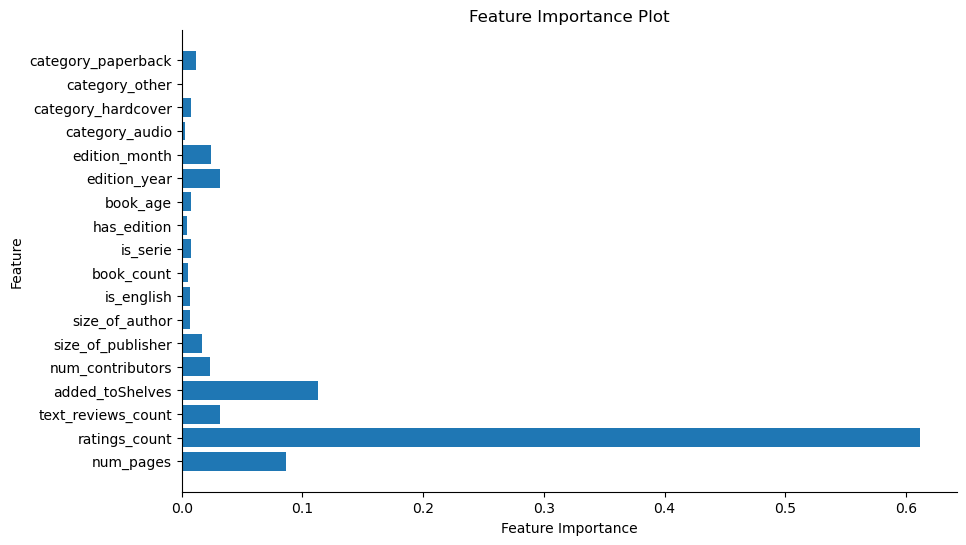

In [22]:
# Get feature importances from the trained ensemble model
feature_importances = ensemble_model.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, tick_label=features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')

# Get the current axes
ax = plt.gca()
# Remove the upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Feature importance is not directly applicable to linear regression models like it is for tree-based ensemble models. In linear regression, the coefficients (also known as weights or slopes) assigned to each feature represent their importance. Features with larger coefficients have a greater impact on the target variable, while features with smaller coefficients have a lesser impact.

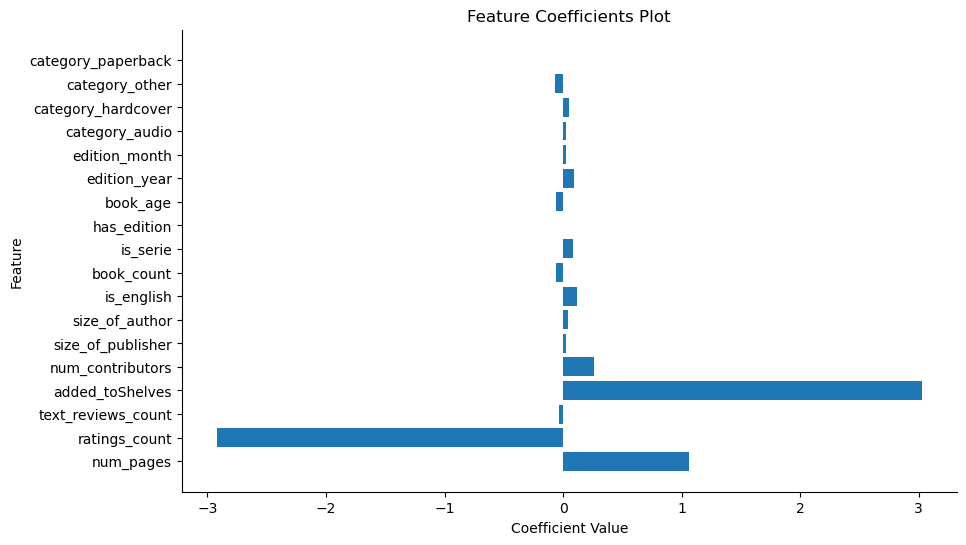

In [21]:
# Assuming reg_model is your trained linear regression model
coefficients = reg_model.coef_

if coefficients.ndim > 1:
    coefficients = coefficients.flatten()

# Create a bar plot of feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(range(len(coefficients)), coefficients, tick_label=features)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Coefficients Plot')

# Get the current axes
ax = plt.gca()
# Remove the upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


Based on the visualizations above, it's evident that certain features have a notable influence on the target variable. Specifically, "num_pages," "ratings_count," "added_toShelves," and "num_contributers" stand out as the most influential features. Additionally, in the context of linear regression, it's worth noting that "ratings_count" has a negative relationship with the target variable.

## Scatter Plot

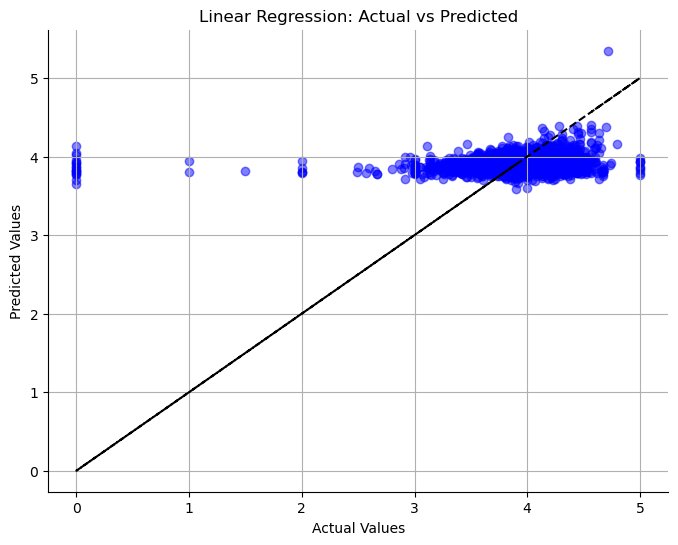

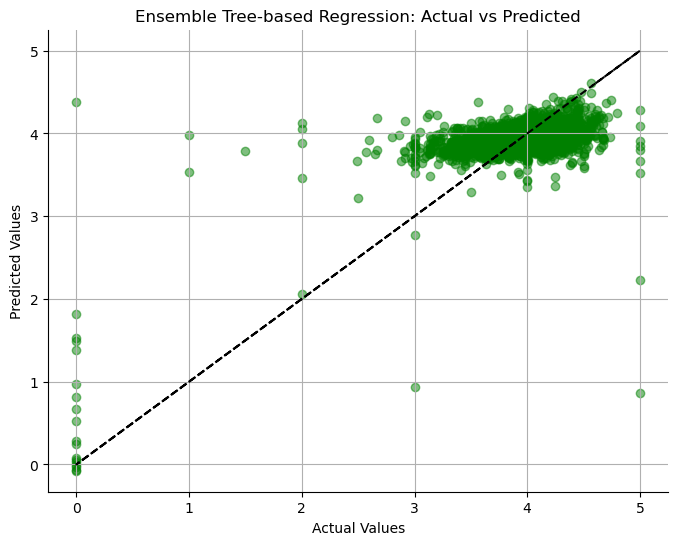

In [28]:
# Scatter plot for Linear Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, reg_model.predict(X_test), color='blue', alpha=0.5)  # Plot actual vs predicted values
plt.plot(y_test, y_test, color='k', linestyle='--')  # Plot the diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.title('Linear Regression: Actual vs Predicted')
# Get the current axes
ax = plt.gca()
# Remove the upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Scatter plot for Ensemble Tree-based Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, ensemble_model.predict(X_test), color='green', alpha=0.5)  # Plot actual vs predicted values
plt.plot(y_test, y_test, color='k', linestyle='--')  # Plot the diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.title('Ensemble Tree-based Regression: Actual vs Predicted')
# Get the current axes
ax = plt.gca()
# Remove the upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


Based on the visualizations above, it's evident that both models demonstrated optimal predictive accuracy within the range of 3.5 to 4.5 average ratings. This observation aligns with the distribution of ratings in our dataset, where the majority fall within this range.

**It's important to note that the current models represent a fundamental starting point. They are very basic and their quality can be further enhanced using various techniques. These techniques include improving the feature engineering approach in order to better capture nuanced relationships within the data, applying hyperparameter tuning methods, such as RandomizedSearchCV or GridSearchCV, so that to find the best parameters that achieve the lowest loss, and using cross-validation techniques (e.g. k-folds) to effectively prevent overfitting, select hyperparameters and analyze model's preformance.**